# Chapter 5. Fine-Tuning Large Language Models



**Note**

As of July 28, 2023, the link to the distribution source of the MARC-ja dataset is broken, and there is an error in the code posted in sections 5.2, 5.3, and 5.5.4 of the book when reading the dataset. It's ready to come out. This notebook is prepared to run the same code as the book using WRIME, which is a sentiment analysis dataset similar to MARC-ja.

## 5.3 Error Analysis of Sentiment Analysis Model

In [1]:
!pip -q install datasets transformers[ja,torch] matplotlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 49.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 22.9 MB/s eta 0:00:00


### 5.3.1 Obtaining Model Prediction Results

In [2]:
from transformers import pipeline

model_name = "llm-book/bert-base-japanese-v3-wrime-sentiment"
sentiment_pipeline = pipeline(model=model_name, device="cuda:0")

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/231k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [3]:
from datasets import load_dataset

valid_dataset = load_dataset("llm-book/wrime-sentiment", split="validation")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [4]:
from tqdm import tqdm

# ClassLabel instance for retrieving label name information
class_label = valid_dataset.features["label"]

results: list[dict[str, float | str]] = []
for i, example in tqdm(enumerate(valid_dataset)):
    # Obtain the model's prediction results
    model_prediction = sentiment_pipeline(example["sentence"])[0]
    # Convert the true label ID to a label name
    true_label = class_label.int2str(example["label"])

    # Store necessary information for analysis in results
    results.append(
        {
            "example_id": i,
            "pred_prob": model_prediction["score"],
            "pred_label": model_prediction["label"],  # The predicted label
            "true_label": true_label,  # The true label
        }
    )

10it [00:01, 12.18it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
1608it [00:41, 38.46it/s]


### 5.3.2 Analyzing Overall Trends

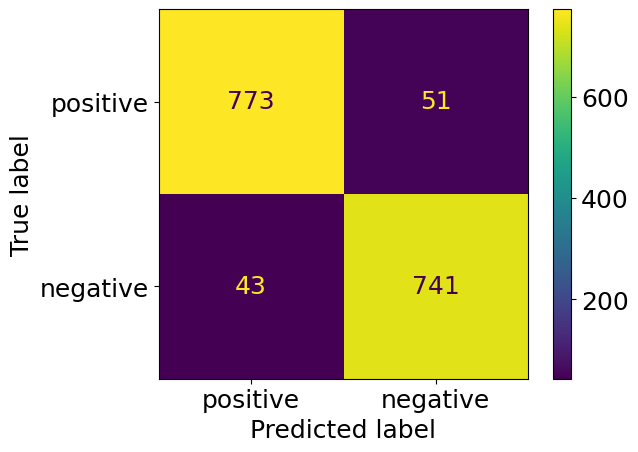

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

plt.rcParams["font.size"] = 18  # Increase the font size

# Creating the confusion matrix
confusion_matrix = confusion_matrix(
    y_true=[result["true_label"] for result in results],
    y_pred=[result["pred_label"] for result in results],
    labels=class_label.names,
)
# Display the confusion matrix as an image
ConfusionMatrixDisplay(
    confusion_matrix, display_labels=class_label.names
).plot()

### 5.3.3 Be Careful with Model Shortcuts

In [6]:
# Collect examples where predictions were incorrect
failed_results = [
    res for res in results if res["pred_label"] != res["true_label"]
]
# Sort by model's prediction probability in descending order
sorted_failed_results = sorted(
    failed_results, key=lambda x: -x["pred_prob"]
)
# Display the top 2 examples with high prediction probability but incorrect predictions
for top_result in sorted_failed_results[:5]:
    review_text = valid_dataset[top_result["example_id"]]["sentence"]
    print(f"レビュー文 (Review Text)：{review_text}")
    print(f"予測 (Prediction)：{top_result['pred_label']}")
    print(f"正解 (True Label)：{top_result['true_label']}")
    print(f"予測確率 (Prediction Probability): {top_result['pred_prob']:.4f}")
    print("----------------")

レビュー文 (Review Text)：何のこれしき会社員だった頃の辛さに比べれば。まあ種類が違うけど。


予測 (Prediction)：negative
正解 (True Label)：positive
予測確率 (Prediction Probability): 0.9993
----------------
レビュー文 (Review Text)：今年のプリキュアの決め台詞が、
 
「お大事に」

今年にマッチングし過ぎてて、プリキュアスタッフの先見の明がすご過ぎるし、何が言いたいかと言うと変身する棒を買わされました。
予測 (Prediction)：positive
正解 (True Label)：negative
予測確率 (Prediction Probability): 0.9993
----------------
レビュー文 (Review Text)：ツイッター早朝部、いくわよ！！ あと諸事情により数人ブロックさせて頂きました…申し訳ない……
予測 (Prediction)：negative
正解 (True Label)：positive
予測確率 (Prediction Probability): 0.9992
----------------
レビュー文 (Review Text)：酒はぬるめの 燗がいい 肴は炙った イカでいい←もっといいもの食えよ
予測 (Prediction)：positive
正解 (True Label)：negative
予測確率 (Prediction Probability): 0.9992
----------------
レビュー文 (Review Text)：できれば今すぐお線香あげにいきたい
予測 (Prediction)：positive
正解 (True Label)：negative
予測確率 (Prediction Probability): 0.9992
----------------
